# 2 - Modular MLP Class

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Neural Network Layer Classes

In [3]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        self.parameters = {
            "weights": np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim),  # He Initialization
            "bias": np.zeros((1, output_dim))
        }
        self.gradient = {}

    def forward(self, x):
        self.input = x
        self.output = np.dot(x, self.parameters["weights"]) + self.parameters["bias"]
        if np.any(np.isnan(self.output)) or np.any(np.isinf(self.output)):
          print("NaN or Inf detected in DenseLayer output")
        return self.output

    def backward(self, gradient):
        self.gradient["weights"] = np.dot(self.input.T, gradient)
        self.gradient["bias"] = np.sum(gradient, axis=0, keepdims=True)
        # Log gradient values
        if np.any(np.isnan(self.gradient["weights"])) or np.any(np.isinf(self.gradient["weights"])):
          print("NaN or Inf detected in DenseLayer weight gradients")
        return np.dot(gradient, self.parameters["weights"].T)



In [4]:
class ReLULayer:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x) # ReLU

    def backward(self, gradient):
        return gradient * (self.input > 0) # Derivative of ReLU


In [5]:
class TanhLayer:

    def forward(self, x):
        self.input_cache = np.tanh(x)  # Tanh activation
        return self.input_cache

    def backward(self, grad_output):
        grad_input = grad_output * (1 - self.input_cache ** 2) # Derivative of Tanh
        return grad_input


In [6]:
class LeakyReLULayer:
    def __init__(self, alpha=0.01):
        self.alpha = alpha # Leaky ReLU hyperparamater

    def forward(self, x):
        self.input_cache = x
        return np.where(x > 0, x, self.alpha * x) # Leaky ReLU

    def backward(self, grad_output):
        grad_input = grad_output * np.where(self.input_cache > 0, 1, self.alpha) # Derivative of Leaky ReLU
        return grad_input


In [7]:
class SigmoidLayer:
    def forward(self, x):
        self.input_cache = 1 / (1 + np.exp(-x))  # Sigmoid activation
        return self.input_cache

    def backward(self, grad_output):
        grad_input = grad_output * self.input_cache * (1 - self.input_cache) # Derivative of Sigmoid
        return grad_input


In [8]:
class SoftmaxLayer:
    def forward(self, x):
        shifted_logits = x - np.max(x, axis=1, keepdims=True)  # Stability improvement
        exp_x = np.exp(shifted_logits)
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True) # Softmax Activation
        return self.output

    def backward(self, gradient):
        return gradient # Pass Softmax through (Always last layer)


In [9]:
class CrossEntropyLoss:
    def __init__(self, l1_reg=0.0, l2_reg=0.0):
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg

    def forward(self, predicted, target, layers=None):
        if np.any(np.isnan(predicted)) or np.any(np.isinf(predicted)):
            print("NaN or Inf detected in predictions before loss")

        # Clip predicted values to avoid log(0) or log(1)
        predicted = np.clip(predicted, 1e-9, 1 - 1e-9)

        # Compute the cross-entropy loss
        log_probs = np.log(predicted[np.arange(len(target)), target])
        loss = -np.mean(log_probs)

        # Add L1 and L2 regularization penalties
        if layers is not None:
            if self.l1_reg > 0:
              l1_penalty = sum(self.l1_reg * np.sum(np.abs(layer.parameters["weights"])) for layer in layers if hasattr(layer, "weights"))
              loss += l1_penalty
            elif self.l2_reg > 0:
              l2_penalty = sum(self.l2_reg * np.sum(layer.parameters["weights"] ** 2) for layer in layers if hasattr(layer, "weights"))
              loss += l2_penalty

        return loss

    def backward(self, predicted, target):
        # Copy to avoid modifying the input
        grad = predicted.copy()
        grad[np.arange(len(target)), target] -= 1
        return grad / target.shape[0]


Gradient descent

In [10]:
class SGD:
    def __init__(self, learning_rate=0.001, clip_value=1000.0, l1_reg=0.0, l2_reg=0.0):
        self.learning_rate = learning_rate
        self.clip_value = clip_value
        self.l1_reg = l1_reg  # L1 regularization coefficient
        self.l2_reg = l2_reg  # L2 regularization coefficient

    def step(self, layers):
        for layer in layers:
            if not hasattr(layer, "parameters") or layer.parameters is None:
                continue

            for param in layer.parameters:
                # Catch invalid regularisation input
                if self.l1_reg > 0 and self.l2_reg > 0:
                    print("L1 and L2 regularization cannot be used together")
                    break

                # L2 regularization gradient
                elif self.l2_reg > 0:
                    layer.gradient[param] += self.l2_reg * layer.parameters[param]

                # Add L1 regularization gradient
                elif self.l1_reg > 0:
                    layer.gradient[param] += self.l1_reg * np.sign(layer.parameters[param])

                # Clip gradients
                np.clip(layer.gradient[param], -self.clip_value, self.clip_value, out=layer.gradient[param])

                # Update weights
                layer.parameters[param] -= self.learning_rate * layer.gradient[param]



In [11]:
class DeepMLP: # MLP class (collects layer classes)
    def __init__(self, *args):
        self.layers = args # General Constructor for NeuralNetlayers
        self.training_losses = []  # Store training losses
        self.validation_losses = []  # Store validation losses
        self.training_accuracies = []  # Store training accuracies
        self.validation_accuracies = []  # Store validation accuracies

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, gradient):
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def fit(self, train_loader, val_loader=None, test_loader=None, loss_fn=None, optimizer=None, epochs=10):

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            total_loss = 0
            total_correct = 0
            total_samples = 0

            # Training loop
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.numpy()
                y_batch = y_batch.numpy()

                # Forward pass
                predictions = self.forward(X_batch)

                # Compute loss
                loss = loss_fn.forward(predictions, y_batch, layers=self.layers)
                total_loss += loss

                # Backward pass
                grad = loss_fn.backward(predictions, y_batch)
                self.backward(grad)

                # Update weights
                optimizer.step(self.layers)

                # Accuracy calculation
                total_correct += np.sum(np.argmax(predictions, axis=1) == y_batch)
                total_samples += y_batch.shape[0]

            # Compute and store average training metrics
            avg_loss = total_loss / len(train_loader)
            train_accuracy = total_correct / total_samples * 100
            self.training_losses.append(avg_loss)
            self.training_accuracies.append(train_accuracy)
            # test_accuracy = self.evaluate_accuracy(test_loader) if test_loader else None

            # Evaluate on validation data
            if val_loader:
                val_loss, val_accuracy = self._compute_metrics(val_loader, loss_fn)
                self.validation_losses.append(val_loss)
                self.validation_accuracies.append(val_accuracy)
                print(f"Training Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}% | "
                      f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
            else:
                print(f"Training Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


    def _compute_metrics(self, data_loader, loss_fn):
            total_loss = 0
            total_correct = 0
            total_samples = 0

            for X_batch, y_batch in data_loader:
                X_batch = X_batch.numpy()
                y_batch = y_batch.numpy()

                # Forward pass
                predictions = self.forward(X_batch)

                # Compute loss
                loss = loss_fn.forward(predictions, y_batch)
                total_loss += loss

                # Accuracy calculation
                total_correct += np.sum(np.argmax(predictions, axis=1) == y_batch)
                total_samples += y_batch.shape[0]

            avg_loss = total_loss / len(data_loader)
            accuracy = total_correct / total_samples * 100
            return avg_loss, accuracy

    def evaluate_accuracy(self, data_loader):

        total_correct = 0
        total_samples = 0

        for X_batch, y_batch in data_loader:
            X_batch = X_batch.numpy()
            y_batch = y_batch.numpy()

            # Forward pass through the entire model
            predictions = self.forward(X_batch)

            # Accuracy calculation
            total_correct += np.sum(np.argmax(predictions, axis=1) == y_batch)
            total_samples += y_batch.shape[0]

      # Return accuracy as a percentage
        return total_correct / total_samples * 100

    def plot_metrics(self):
            # Plot Loss
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(self.training_losses) + 1), self.training_losses, label="Training Loss")
            if self.validation_losses:
                plt.plot(range(1, len(self.validation_losses) + 1), self.validation_losses, label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training and Validation Loss Over Epochs")
            plt.legend()
            plt.show()

            # Plot Accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, len(self.training_accuracies) + 1), self.training_accuracies, label="Training Accuracy")
            if self.validation_accuracies:
                plt.plot(range(1, len(self.validation_accuracies) + 1), self.validation_accuracies, label="Validation Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy (%)")
            plt.title("Training and Validation Accuracy Over Epochs")
            plt.legend()
            plt.show()

In [12]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a84db34fd0770a850dbf38c6424c0a6b524aece31ac394b1aeaed2d615e625ee
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


Loading and processing data

## 1 - Load and Transform Data

In [17]:
import numpy as np
from medmnist import OrganAMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Custom wrapper to flatten labels
class FlattenLabelsWrapper:
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        y = np.array(y).squeeze()  # Ensure labels are 1D
        return X, y

# Load the dataset
train_dataset = OrganAMNIST(split="train", download=True, transform=transforms.ToTensor())
val_dataset = OrganAMNIST(split="val", transform=transforms.ToTensor())
test_dataset = OrganAMNIST(split="test", transform=transforms.ToTensor())

# Normalize the data (Compute mean and std for normalization)
train_loader_raw = DataLoader(train_dataset, batch_size=len(train_dataset))
train_data, _ = next(iter(train_loader_raw))
mean = train_data.mean().item()
std = train_data.std().item()

print(f"Mean: {mean}, Standard Deviation: {std}")

# Transform: Normalize and Flatten
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std]),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to vector
])

# Apply transformations to datasets
train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform

# Wrap datasets to flatten labels
train_dataset = FlattenLabelsWrapper(train_dataset)
val_dataset = FlattenLabelsWrapper(val_dataset)
test_dataset = FlattenLabelsWrapper(test_dataset)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Debugging: Check the first batch
X_batch, y_batch = next(iter(train_loader))
print(f"X_batch shape: {X_batch.shape}")  # Should be (batch_size, flattened_input_dim)
print(f"y_batch shape: {y_batch.shape}")  # Should be (batch_size,)


print("Data prepared and loaders created!")


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Mean: 0.4680282473564148, Standard Deviation: 0.2974209487438202
X_batch shape: torch.Size([64, 784])
y_batch shape: torch.Size([64])
Data prepared and loaders created!


In [18]:
# Check data does not contain potentially invalid values
for X_batch, y_batch in train_loader:
    if np.any(np.isnan(X_batch.numpy())) or np.any(np.isinf(X_batch.numpy())):
        print("Input contains NaN or Inf")


## 3.1 - Fit 3 Models with Different Numbers of Layers

In [19]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

nohidden = DeepMLP(
    DenseLayer(784, 11),  # Fully connected layer
    SoftmaxLayer()         # Keep Softmax for classification
)

onehidden = DeepMLP(
    DenseLayer(784, 256),
    ReLULayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)

twohidden = DeepMLP(
    DenseLayer(784, 256),
    ReLULayer(),
    DenseLayer(256, 256),
    ReLULayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)


In [45]:
# Fit the model
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

# Train the no layer model
print("---- No Layer Model -----")
nohidden.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    # test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)

---- No Layer Model -----
Epoch 1/10
Training Loss: 1.1761, Training Accuracy: 62.69% | Validation Loss: 0.6428, Validation Accuracy: 79.12%
Epoch 2/10
Training Loss: 0.9374, Training Accuracy: 71.33% | Validation Loss: 0.6033, Validation Accuracy: 80.19%
Epoch 3/10
Training Loss: 0.8754, Training Accuracy: 73.42% | Validation Loss: 1.2461, Validation Accuracy: 65.37%
Epoch 4/10
Training Loss: 0.8392, Training Accuracy: 74.70% | Validation Loss: 0.5604, Validation Accuracy: 82.64%
Epoch 5/10
Training Loss: 0.7994, Training Accuracy: 75.88% | Validation Loss: 0.5841, Validation Accuracy: 81.70%
Epoch 6/10
Training Loss: 0.7720, Training Accuracy: 76.78% | Validation Loss: 0.5538, Validation Accuracy: 82.61%
Epoch 7/10
Training Loss: 0.7443, Training Accuracy: 77.47% | Validation Loss: 0.5444, Validation Accuracy: 83.16%
Epoch 8/10
Training Loss: 0.7250, Training Accuracy: 78.10% | Validation Loss: 0.5486, Validation Accuracy: 83.05%
Epoch 9/10
Training Loss: 0.7154, Training Accuracy: 7

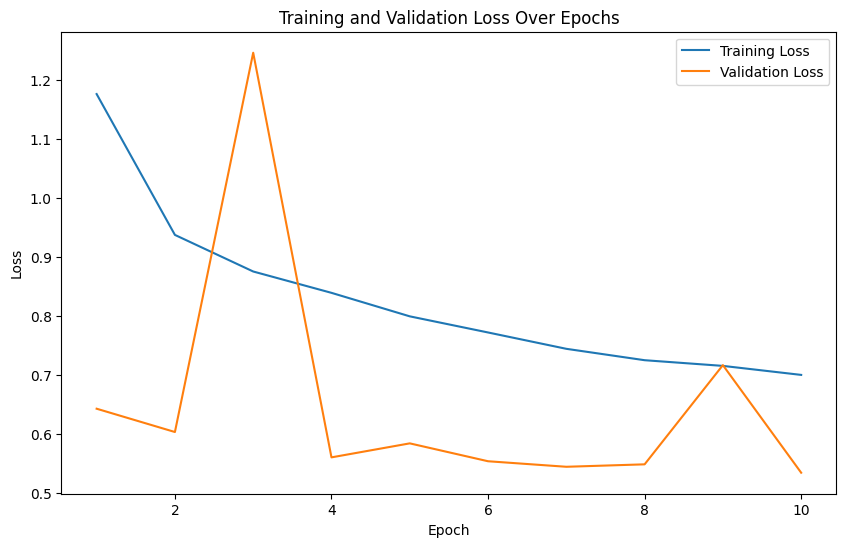

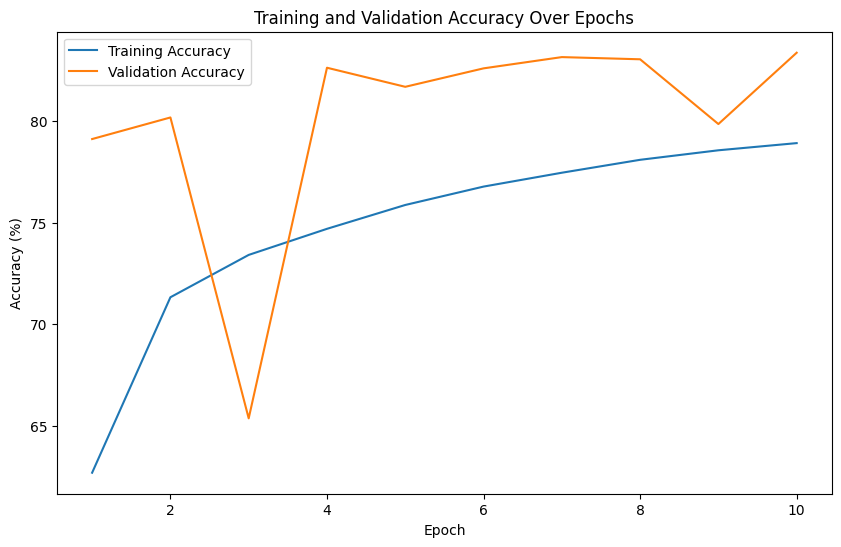

In [46]:
nohidden.plot_metrics()

In [47]:
test_loss, test_acc = nohidden._compute_metrics(test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.2120, Test Accuracy: 60.94%


In [48]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

# Train the one layer model
print("---- One Layer Model -----")
onehidden.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    # test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)


---- One Layer Model -----
Epoch 1/10
Training Loss: 0.9501, Training Accuracy: 68.15% | Validation Loss: 0.5008, Validation Accuracy: 86.43%
Epoch 2/10
Training Loss: 0.6057, Training Accuracy: 79.95% | Validation Loss: 0.4433, Validation Accuracy: 88.32%
Epoch 3/10
Training Loss: 0.4955, Training Accuracy: 84.26% | Validation Loss: 0.4097, Validation Accuracy: 89.39%
Epoch 4/10
Training Loss: 0.4244, Training Accuracy: 86.99% | Validation Loss: 0.4342, Validation Accuracy: 87.69%
Epoch 5/10
Training Loss: 0.3701, Training Accuracy: 89.04% | Validation Loss: 0.3901, Validation Accuracy: 90.28%
Epoch 6/10
Training Loss: 0.3284, Training Accuracy: 90.49% | Validation Loss: 0.3778, Validation Accuracy: 90.57%
Epoch 7/10
Training Loss: 0.2943, Training Accuracy: 91.81% | Validation Loss: 0.3774, Validation Accuracy: 90.48%
Epoch 8/10
Training Loss: 0.2657, Training Accuracy: 92.78% | Validation Loss: 0.3721, Validation Accuracy: 90.79%
Epoch 9/10
Training Loss: 0.2413, Training Accuracy: 

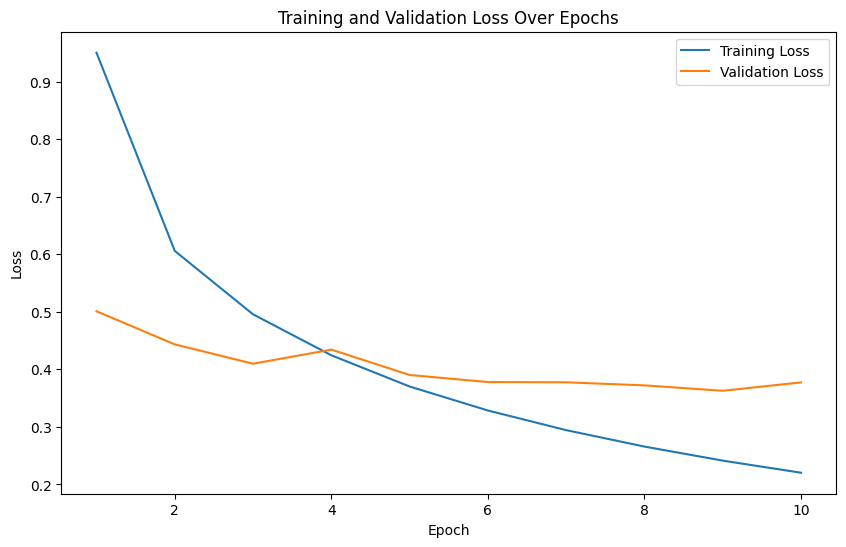

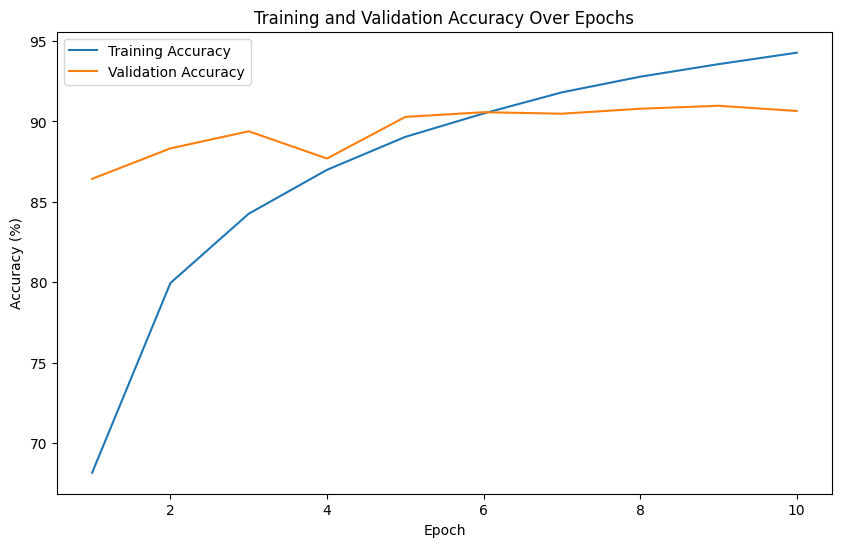

In [49]:
onehidden.plot_metrics()

In [50]:
test_loss, test_acc = onehidden._compute_metrics(test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.8995, Test Accuracy: 71.55%


In [20]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

# Train the two layer model
print("---- Two Layer Model -----")
twohidden.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    # test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)


---- Two Layer Model -----
Epoch 1/10
Training Loss: 0.9535, Training Accuracy: 68.24% | Validation Loss: 0.4561, Validation Accuracy: 87.00%
Epoch 2/10
Training Loss: 0.5529, Training Accuracy: 81.74% | Validation Loss: 0.3800, Validation Accuracy: 89.69%
Epoch 3/10
Training Loss: 0.4270, Training Accuracy: 86.57% | Validation Loss: 0.9717, Validation Accuracy: 73.78%
Epoch 4/10
Training Loss: 0.3533, Training Accuracy: 89.47% | Validation Loss: 2.9552, Validation Accuracy: 61.05%
Epoch 5/10
Training Loss: 0.2953, Training Accuracy: 91.59% | Validation Loss: 0.4321, Validation Accuracy: 87.47%
Epoch 6/10
Training Loss: 0.2449, Training Accuracy: 93.38% | Validation Loss: 0.5010, Validation Accuracy: 83.89%
Epoch 7/10
Training Loss: 0.2038, Training Accuracy: 94.57% | Validation Loss: 0.3657, Validation Accuracy: 90.09%
Epoch 8/10
Training Loss: 0.1738, Training Accuracy: 95.51% | Validation Loss: 0.3902, Validation Accuracy: 89.76%
Epoch 9/10
Training Loss: 0.1493, Training Accuracy: 

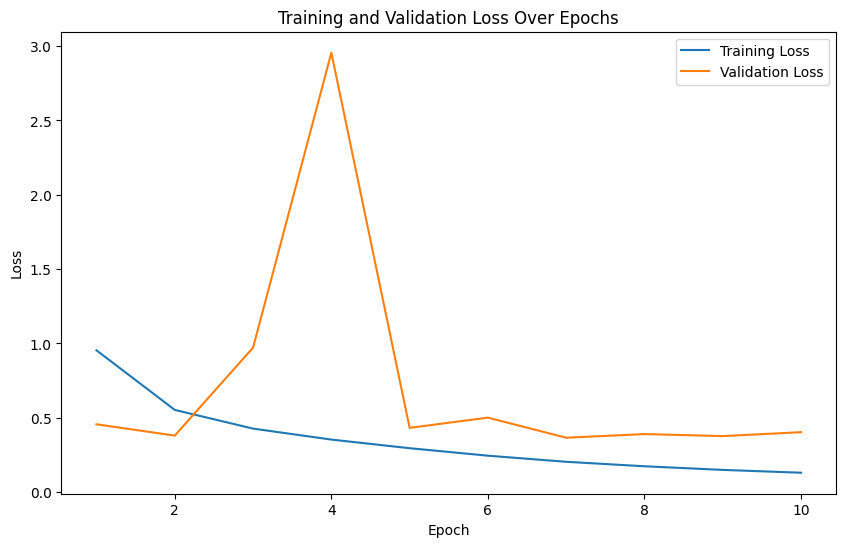

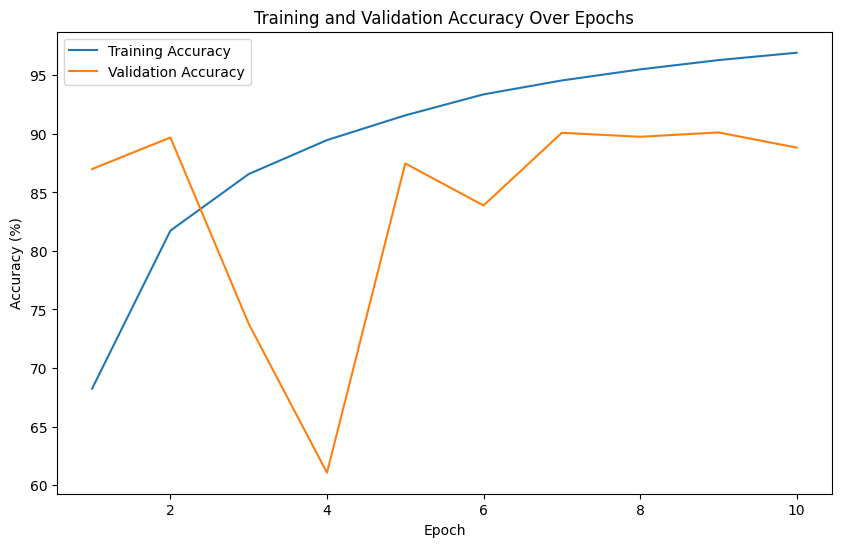

In [21]:
twohidden.plot_metrics()

In [22]:
test_loss, test_acc = twohidden._compute_metrics(test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.0387, Test Accuracy: 70.65%


## 3.2 - Tanh and Leaky-ReLU


In [54]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

# Tanh activations models
twohiddentanh = DeepMLP(
    DenseLayer(784, 256),
    TanhLayer(),
    DenseLayer(256, 256),
    TanhLayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)

In [55]:
# Train the model with Tanh activation functions
print("---- Tanh Model -----")
twohiddentanh.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    # test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)

---- Tanh Model -----
Epoch 1/10
Training Loss: 1.0994, Training Accuracy: 66.36% | Validation Loss: 0.5656, Validation Accuracy: 84.44%
Epoch 2/10
Training Loss: 0.7527, Training Accuracy: 77.77% | Validation Loss: 0.4597, Validation Accuracy: 88.43%
Epoch 3/10
Training Loss: 0.6239, Training Accuracy: 81.81% | Validation Loss: 0.4090, Validation Accuracy: 89.49%
Epoch 4/10
Training Loss: 0.5339, Training Accuracy: 84.84% | Validation Loss: 0.3962, Validation Accuracy: 89.80%
Epoch 5/10
Training Loss: 0.4628, Training Accuracy: 87.11% | Validation Loss: 0.3791, Validation Accuracy: 90.23%
Epoch 6/10
Training Loss: 0.4041, Training Accuracy: 89.07% | Validation Loss: 0.3622, Validation Accuracy: 90.34%
Epoch 7/10
Training Loss: 0.3589, Training Accuracy: 90.67% | Validation Loss: 0.4847, Validation Accuracy: 85.13%
Epoch 8/10
Training Loss: 0.3180, Training Accuracy: 91.85% | Validation Loss: 0.3515, Validation Accuracy: 90.54%
Epoch 9/10
Training Loss: 0.2774, Training Accuracy: 93.08

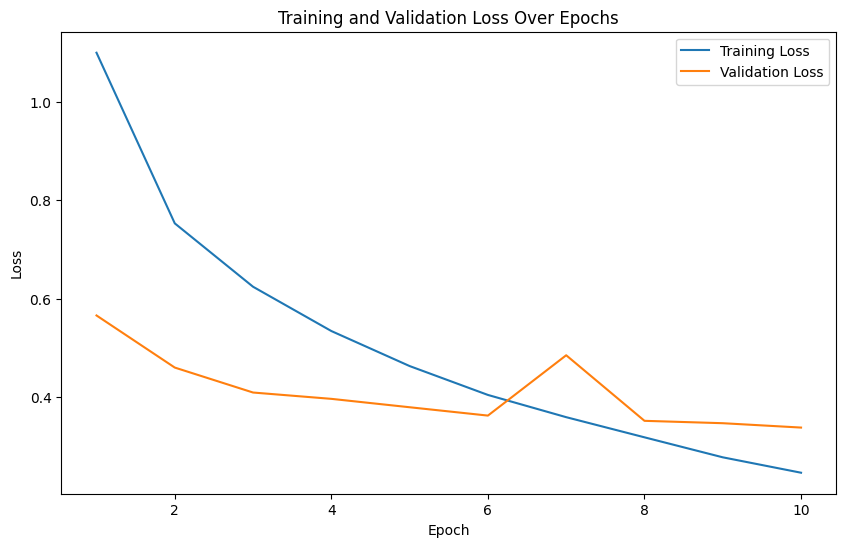

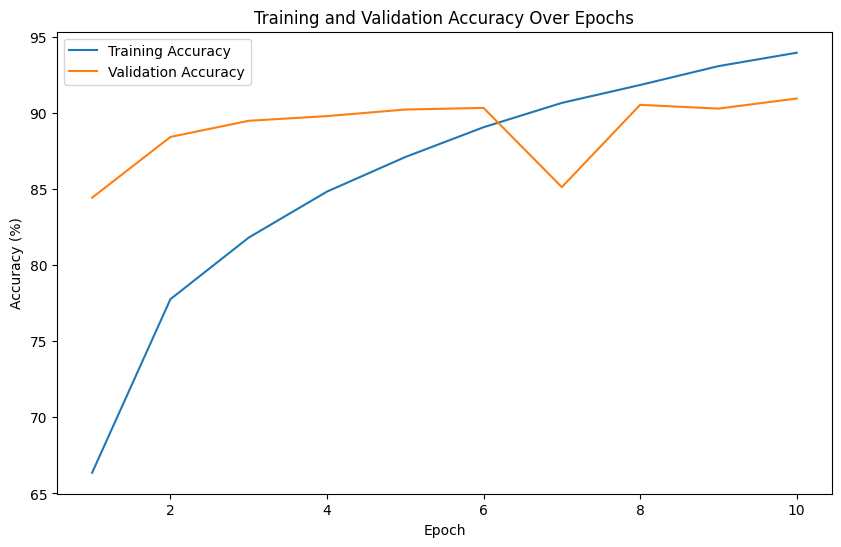

In [56]:
twohiddentanh.plot_metrics()

In [57]:
test_loss, test_acc = twohiddentanh._compute_metrics(test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.9496, Test Accuracy: 69.12%


In [58]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

# Leaky ReLU activations models
twohiddenleaky = DeepMLP(
    DenseLayer(784, 256),
    LeakyReLULayer(),
    DenseLayer(256, 256),
    LeakyReLULayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)

In [59]:
# Train the model with Leaky ReLU activation functions
print("---- Leaky ReLU Model -----")
twohiddenleaky.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    # test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)

---- Leaky ReLU Model -----
Epoch 1/10
Training Loss: 0.9227, Training Accuracy: 68.99% | Validation Loss: 0.4781, Validation Accuracy: 85.80%
Epoch 2/10
Training Loss: 0.5446, Training Accuracy: 82.27% | Validation Loss: 0.3911, Validation Accuracy: 89.29%
Epoch 3/10
Training Loss: 0.4263, Training Accuracy: 86.62% | Validation Loss: 0.7355, Validation Accuracy: 75.52%
Epoch 4/10
Training Loss: 0.3501, Training Accuracy: 89.38% | Validation Loss: 0.5838, Validation Accuracy: 81.99%
Epoch 5/10
Training Loss: 0.2868, Training Accuracy: 91.62% | Validation Loss: 0.3641, Validation Accuracy: 90.20%
Epoch 6/10
Training Loss: 0.2397, Training Accuracy: 93.45% | Validation Loss: 0.3804, Validation Accuracy: 89.86%
Epoch 7/10
Training Loss: 0.2047, Training Accuracy: 94.40% | Validation Loss: 0.3725, Validation Accuracy: 89.97%
Epoch 8/10
Training Loss: 0.1768, Training Accuracy: 95.45% | Validation Loss: 0.3878, Validation Accuracy: 89.72%
Epoch 9/10
Training Loss: 0.1519, Training Accuracy:

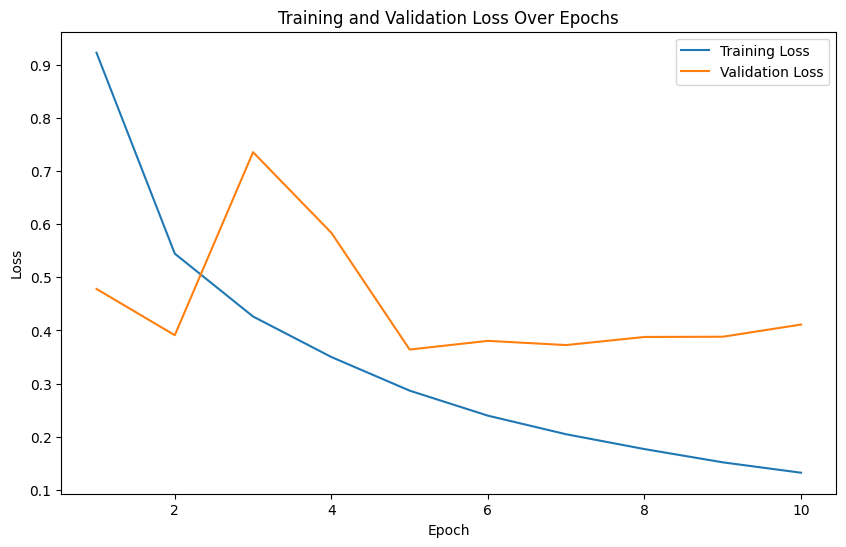

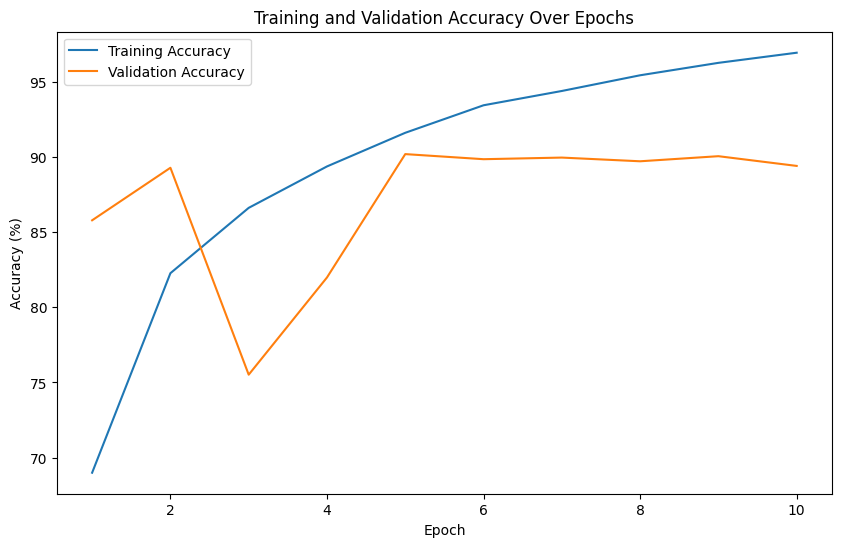

In [60]:
twohiddenleaky.plot_metrics()

In [61]:
test_loss, test_acc = twohiddenleaky._compute_metrics(test_loader, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.9811, Test Accuracy: 70.79%


## 3.3 - L1 and L2 Regularized MLP

In [62]:
# Two layer ReLU model with L1
twohiddenl1 = DeepMLP(
    DenseLayer(784, 256),
    ReLULayer(),
    DenseLayer(256, 256),
    ReLULayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)

# Two layer ReLU model with L2
twohiddenl2 = DeepMLP(
    DenseLayer(784, 256),
    ReLULayer(),
    DenseLayer(256, 256),
    ReLULayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)


In [63]:
# L1 Parameter
l1_reg = 1e-3

# Define the loss function and optimizer
loss_fn_l1 = CrossEntropyLoss(l1_reg=l1_reg)
optimizer_l1 = SGD(learning_rate=0.01, l1_reg=l1_reg)

# Train L1 model
print("---- L1 Model -----")
twohiddenl1.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    # test_loader=test_loader,
    loss_fn=loss_fn_l1,
    optimizer=optimizer_l1,
    epochs=10
)

---- L1 Model -----
Epoch 1/10
Training Loss: 0.9165, Training Accuracy: 69.59% | Validation Loss: 0.4577, Validation Accuracy: 88.14%
Epoch 2/10
Training Loss: 0.5872, Training Accuracy: 81.16% | Validation Loss: 0.4076, Validation Accuracy: 90.34%
Epoch 3/10
Training Loss: 0.4941, Training Accuracy: 84.74% | Validation Loss: 0.3835, Validation Accuracy: 90.42%
Epoch 4/10
Training Loss: 0.4445, Training Accuracy: 87.04% | Validation Loss: 0.3682, Validation Accuracy: 90.66%
Epoch 5/10
Training Loss: 0.4128, Training Accuracy: 88.40% | Validation Loss: 0.3655, Validation Accuracy: 90.77%
Epoch 6/10
Training Loss: 0.3943, Training Accuracy: 89.37% | Validation Loss: 0.4940, Validation Accuracy: 84.81%
Epoch 7/10
Training Loss: 0.3829, Training Accuracy: 89.95% | Validation Loss: 0.3550, Validation Accuracy: 91.42%
Epoch 8/10
Training Loss: 0.3779, Training Accuracy: 90.49% | Validation Loss: 0.9015, Validation Accuracy: 74.86%
Epoch 9/10
Training Loss: 0.3764, Training Accuracy: 90.65% 

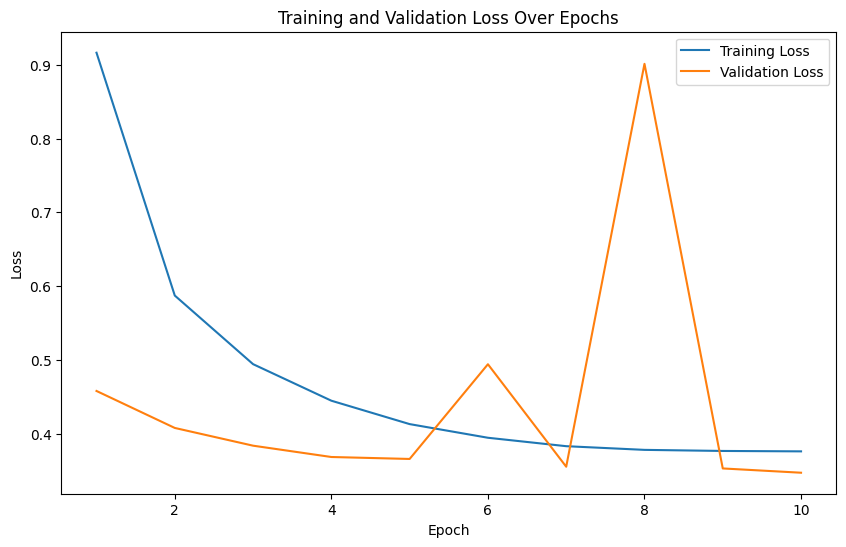

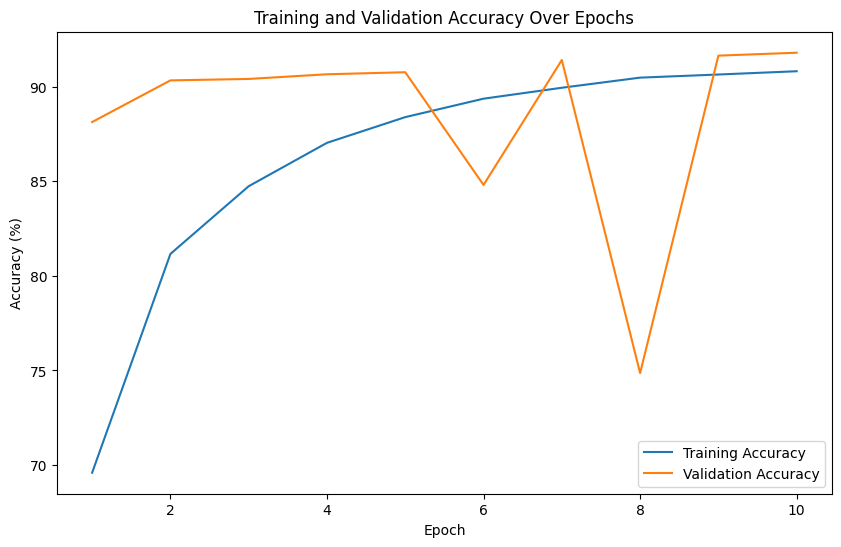

In [64]:
twohiddenl1.plot_metrics()

In [65]:
test_loss, test_acc = twohiddenl1._compute_metrics(test_loader, loss_fn_l1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.8372, Test Accuracy: 72.18%


In [66]:
# L2 Parameter
l2_reg = 1e-3

# Define the loss function and optimizer
loss_fn_l2 = CrossEntropyLoss(l2_reg=l2_reg)
optimizer_l2 = SGD(learning_rate=0.01, l2_reg=l2_reg)

# Train L1 model
print("---- L2 Model -----")
twohiddenl2.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    # test_loader=test_loader,
    loss_fn=loss_fn_l2,
    optimizer=optimizer_l2,
    epochs=10
)

---- L2 Model -----
Epoch 1/10
Training Loss: 0.9111, Training Accuracy: 69.35% | Validation Loss: 0.4553, Validation Accuracy: 87.83%
Epoch 2/10
Training Loss: 0.5463, Training Accuracy: 81.62% | Validation Loss: 0.3950, Validation Accuracy: 89.37%
Epoch 3/10
Training Loss: 0.4296, Training Accuracy: 86.23% | Validation Loss: 0.4630, Validation Accuracy: 86.12%
Epoch 4/10
Training Loss: 0.3538, Training Accuracy: 89.08% | Validation Loss: 0.3677, Validation Accuracy: 90.31%
Epoch 5/10
Training Loss: 0.2931, Training Accuracy: 91.56% | Validation Loss: 0.3537, Validation Accuracy: 90.63%
Epoch 6/10
Training Loss: 0.2499, Training Accuracy: 93.05% | Validation Loss: 0.3666, Validation Accuracy: 90.14%
Epoch 7/10
Training Loss: 0.2143, Training Accuracy: 94.29% | Validation Loss: 0.3711, Validation Accuracy: 90.14%
Epoch 8/10
Training Loss: 0.1864, Training Accuracy: 95.23% | Validation Loss: 0.4933, Validation Accuracy: 86.13%
Epoch 9/10
Training Loss: 0.1642, Training Accuracy: 95.95% 

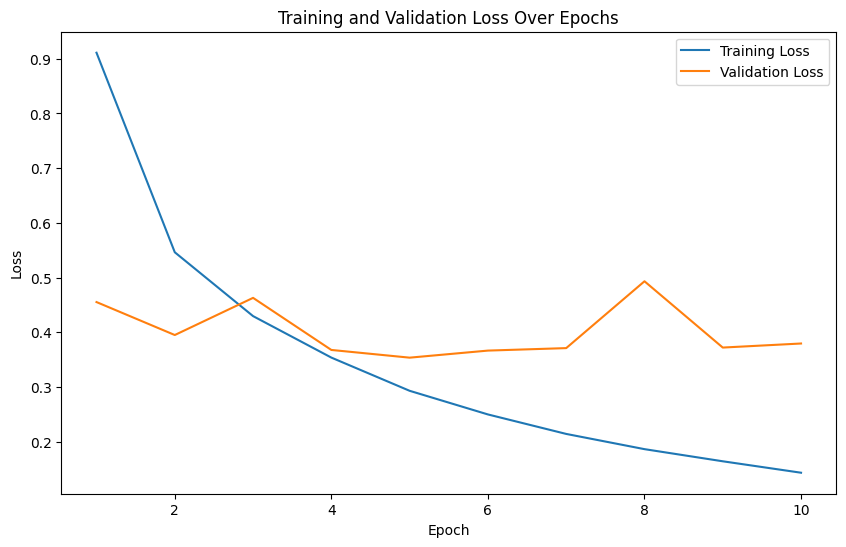

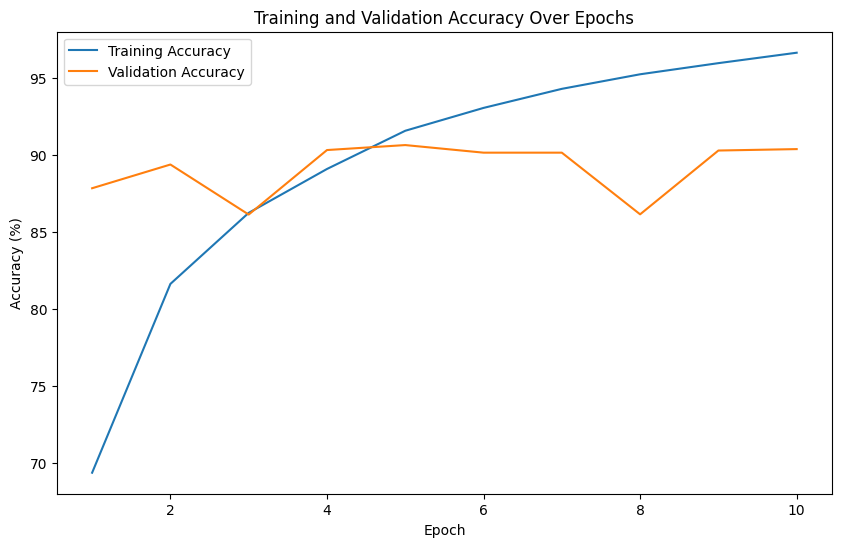

In [67]:
twohiddenl2.plot_metrics()

In [68]:
test_loss, test_acc = twohiddenl2._compute_metrics(test_loader, loss_fn_l2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.9165, Test Accuracy: 71.39%


## 3.4 - Model Trained on Unnormalized Data

In [69]:
# Transform Unnormalized: Only Flatten
transform_unnormalized = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to vector
])

# Load the dataset with unnormalized preprocessing
train_dataset_unnormalized = OrganAMNIST(split="train", download=True, transform=transform_unnormalized)
val_dataset_unnormalized = OrganAMNIST(split="val", transform=transform_unnormalized)
test_dataset_unnormalized = OrganAMNIST(split="test", transform=transform_unnormalized)

# Wrap datasets to flatten labels
train_dataset_unnormalized = FlattenLabelsWrapper(train_dataset_unnormalized)
val_dataset_unnormalized = FlattenLabelsWrapper(val_dataset_unnormalized)
test_dataset_unnormalized = FlattenLabelsWrapper(test_dataset_unnormalized)

# Create DataLoaders
batch_size = 64
train_loader_unnormalized = DataLoader(train_dataset_unnormalized, batch_size=batch_size, shuffle=True)
val_loader_unnormalized = DataLoader(val_dataset_unnormalized, batch_size=batch_size, shuffle=False)
test_loader_unnormalized = DataLoader(test_dataset_unnormalized, batch_size=batch_size, shuffle=False)

# Debugging: Check the first batch
X_batch, y_batch = next(iter(train_loader_unnormalized))
print(f"X_batch shape: {X_batch.shape}")  # Should be (batch_size, flattened_input_dim)
print(f"y_batch shape: {y_batch.shape}")  # Should be (batch_size,)

print("Unnormalized data prepared and loaders created!")

Using downloaded and verified file: /root/.medmnist/organamnist.npz
X_batch shape: torch.Size([64, 784])
y_batch shape: torch.Size([64])
Unnormalized data prepared and loaders created!


In [70]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

# Two layer ReLU model for unnormalized data
twohiddenUnnorlamized = DeepMLP(
    DenseLayer(784, 256),
    ReLULayer(),
    DenseLayer(256, 256),
    ReLULayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)

In [71]:
# Train the model with Leaky ReLU activation functions
print("---- ReLU Model on Unnormalized Data -----")
twohiddenUnnorlamized.fit(
    train_loader=train_loader_unnormalized,
    val_loader=val_loader_unnormalized,
    # test_loader=test_loader_unnormalized,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)

---- ReLU Model on Unnormalized Data -----
Epoch 1/10
Training Loss: 1.3677, Training Accuracy: 56.34% | Validation Loss: 1.2925, Validation Accuracy: 56.25%
Epoch 2/10
Training Loss: 0.9281, Training Accuracy: 69.21% | Validation Loss: 4.0942, Validation Accuracy: 43.89%
Epoch 3/10
Training Loss: 0.7999, Training Accuracy: 73.68% | Validation Loss: 4.9703, Validation Accuracy: 35.28%
Epoch 4/10
Training Loss: 0.7283, Training Accuracy: 76.00% | Validation Loss: 4.7987, Validation Accuracy: 45.12%
Epoch 5/10
Training Loss: 0.6579, Training Accuracy: 78.41% | Validation Loss: 0.4456, Validation Accuracy: 87.17%
Epoch 6/10
Training Loss: 0.5975, Training Accuracy: 80.15% | Validation Loss: 0.4083, Validation Accuracy: 88.20%
Epoch 7/10
Training Loss: 0.5571, Training Accuracy: 81.74% | Validation Loss: 0.3792, Validation Accuracy: 89.46%
Epoch 8/10
Training Loss: 0.5220, Training Accuracy: 83.02% | Validation Loss: 3.3372, Validation Accuracy: 45.06%
Epoch 9/10
Training Loss: 0.5019, Tra

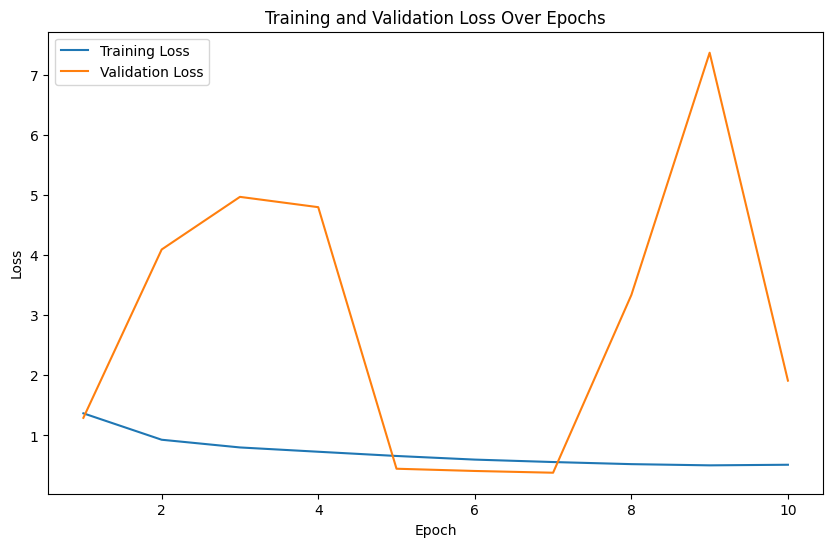

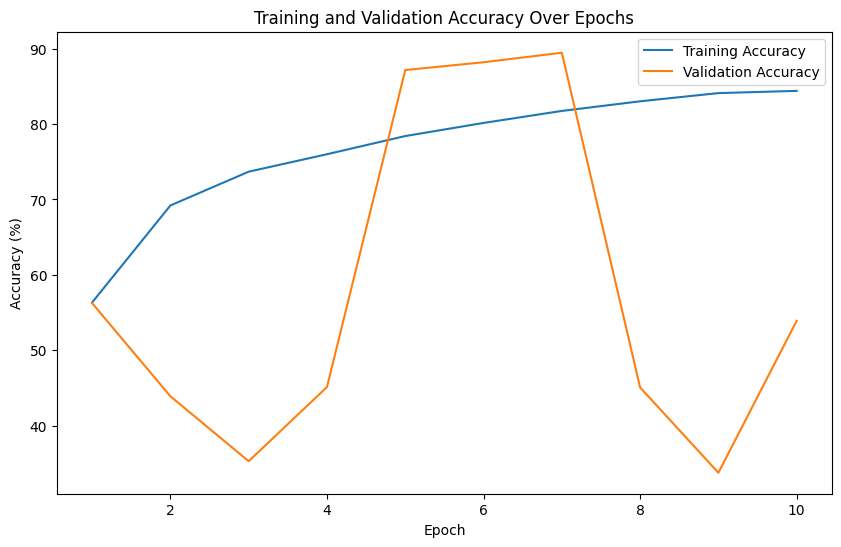

In [82]:
twohiddenUnnorlamized.plot_metrics()

In [83]:
test_loss, test_acc = twohiddenUnnorlamized._compute_metrics(test_loader_unnormalized, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 2.7623, Test Accuracy: 42.07%


## 3.5 - Training on 128x128 Pixel Data

In [78]:
# Load 128x128 data
train_dataset_128px = OrganAMNIST(split="train", download=True, size=128, transform=transforms.ToTensor())
val_dataset_128px = OrganAMNIST(split="val", size=128, transform=transforms.ToTensor())
test_dataset_128px = OrganAMNIST(split="test", size=128, transform=transforms.ToTensor())

Using downloaded and verified file: /root/.medmnist/organamnist_128.npz


In [79]:
# Normalize and Flatten

# Compute mean and std for the 128-pixel dataset
train_loader_raw = DataLoader(train_dataset_128px, batch_size=len(train_dataset_128px))
train_data, _ = next(iter(train_loader_raw))
mean_128px = train_data.mean().item()
std_128px = train_data.std().item()

# Define normalization transform for 128-pixel data
transform_128px = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean_128px], std=[std_128px]),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to vector
])

# Apply transformations to the datasets
train_dataset_128px.transform = transform_128px
val_dataset_128px.transform = transform_128px
test_dataset_128px.transform = transform_128px

batch_size = 64

# Wrap datasets to flatten labels --> Normalized
train_dataset_128px = FlattenLabelsWrapper(train_dataset_128px)
val_dataset_128px = FlattenLabelsWrapper(val_dataset_128px)
test_dataset_128px = FlattenLabelsWrapper(test_dataset_128px)

train_loader_128px = DataLoader(train_dataset_128px, batch_size=batch_size, shuffle=True)
val_loader_128px = DataLoader(val_dataset_128px, batch_size=batch_size, shuffle=False)
test_loader_128px = DataLoader(test_dataset_128px, batch_size=batch_size, shuffle=False)

In [74]:
# MLP for 128-pixel
mlp_128px = DeepMLP(
    DenseLayer(128 * 128, 256),
    ReLULayer(),
    DenseLayer(256, 256),
    ReLULayer(),
    DenseLayer(256, 11),
    SoftmaxLayer()
)

In [75]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(learning_rate=0.01)

# Train 128x128 the model
print("---- 128x128 Model -----")
mlp_128px.fit(
    train_loader=train_loader_128px,
    val_loader=val_loader_128px,
    # test_loader=test_loader_128px,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)

---- 128x128 Model -----
Epoch 1/10
Training Loss: 0.4643, Training Accuracy: 85.47% | Validation Loss: 0.3665, Validation Accuracy: 90.91%
Epoch 2/10
Training Loss: 0.1611, Training Accuracy: 95.78% | Validation Loss: 0.3642, Validation Accuracy: 91.62%
Epoch 3/10
Training Loss: 0.0923, Training Accuracy: 97.81% | Validation Loss: 0.3642, Validation Accuracy: 91.43%
Epoch 4/10
Training Loss: 0.0604, Training Accuracy: 98.83% | Validation Loss: 0.3981, Validation Accuracy: 90.96%
Epoch 5/10
Training Loss: 0.0436, Training Accuracy: 99.17% | Validation Loss: 0.4389, Validation Accuracy: 89.39%
Epoch 6/10
Training Loss: 0.0309, Training Accuracy: 99.53% | Validation Loss: 0.4039, Validation Accuracy: 91.26%
Epoch 7/10
Training Loss: 0.0240, Training Accuracy: 99.68% | Validation Loss: 0.4165, Validation Accuracy: 90.86%
Epoch 8/10
Training Loss: 0.0187, Training Accuracy: 99.81% | Validation Loss: 0.4226, Validation Accuracy: 91.00%
Epoch 9/10
Training Loss: 0.0154, Training Accuracy: 99

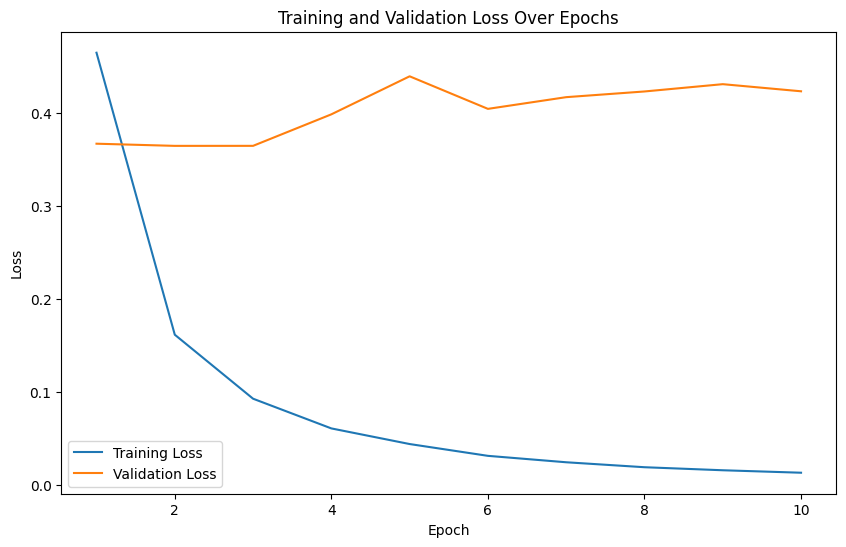

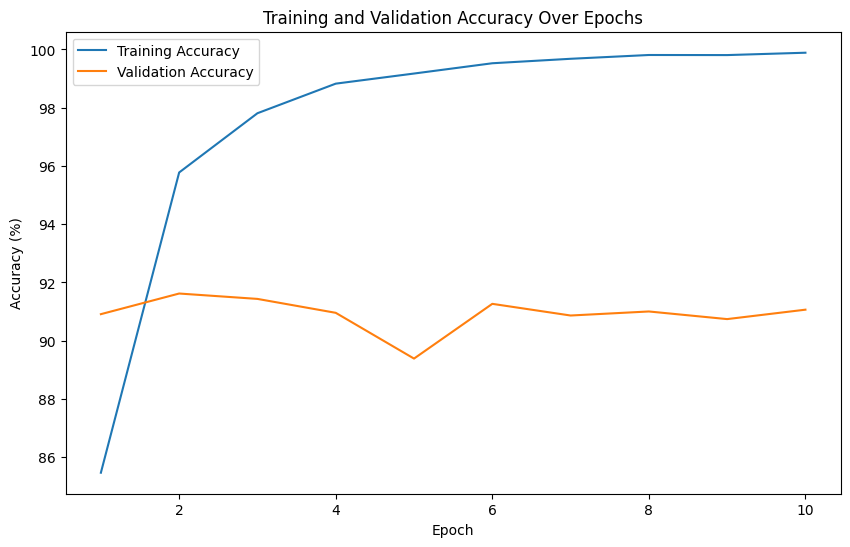

In [80]:
mlp_128px.plot_metrics()

In [81]:
test_loss, test_acc = mlp_128px._compute_metrics(test_loader_128px, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 1.1373, Test Accuracy: 73.30%
